## Scintillation detector data for unfolding

*Erik Hogenbirk, ehogenbi@nikhef.nl, May/June 2016 *

The notebook here is to read in the data read from a NE213 scintillation detector. The output is a 2d histogram with on the x axis the energy (in channels, uncalibrated) and on the y axis some discrimination parameter. It is yet unknown what this is, exactly.

This notebook reads the following datasets:
  * Gamma calibration. There are three datasets, corresponding to three gamma sources. As some of these emit multiple gamma energies, this gives a calibration on six points.
  * Background. We need this to take away the gamma background. Further explanation given further on;
  * Neutron generator data. This was taken at different positions and NG settings.
  
There are some decisions that need to be made... The most important:
  * **Gamma calibration**: In this note, I show an analysis based on the Compton edge that is determined as the 50% amplitude point in the spectra. A second analysis is by Monte Carlo matching, the result of which is shown here too. For now, we **take the MC matched result** but the difference is not too large anyway.
  * **Background rejection**: We can either cut away the gamma background (for instance, with some percentile) or subtract the background. In this note we do both.
  * **Combination**: Run 0 and 1 have exactly the same settings and are highest in statistics. No clear difference is observed between any of the other runs and this one. A total of five datasets are read. The main results (called ``fg_*`` of ``bg_*``, without a number, are the combination of two runs with the same, optimal conditions. 

### Settings

In [1]:
plot = True

### Function definitions

In [2]:
# This notebook has some special functions that are stashed away.
# Most important functions:
#  - get_spectrum : read the spectrum from the ASCII file
#  - find_line: auxilary function for get_spectrum to find the start position in the ASCII file.
#  - get_fwhm_pos : find the position of the half maximum for the gamma calibration.
#  - get_compton_energy: calculate Compton edge energy based on gamma initial energy
%run function_definitions.ipynb
my_colors = ['blue', 'green', 'red']

### Data location

In [3]:
cal_filenames = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_8.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_9.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_10.MPA']
cal_labels = [
    'Bi-207',
    'Na-22',
    'Cs-137']
bg_filenames = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_12.mpa',
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_1.mpa']
bg_livetimes = [
    36001.78,
    40002.56
    ]
ng_filenames = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_7.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_1.mpa', # 50 kV 2.5 mA 0° (SAME SETTINGS!)
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_2.mpa', # 40 kV 1.0 mA +140°
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_2.mpa', # 40 kV 0.5 mA +140°
    './PTB_DATA/2016_JUN_03/2016_JUN_03_2_5MeV_NE213_FG_1.mpa', # 50 kV 0.5 mA +140°
    ]
ng_livetimes = [
    9806.20,
    11950.19,
    22654.55,
    46199.75,
    24747.66
    ]

# For the combination
fg_livetime = ng_livetimes[0] + ng_livetimes[1]
bg_livetime = sum(bg_livetimes)

### Gamma calibration

In [4]:
bg_livetime/3600

21.112316666666665

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


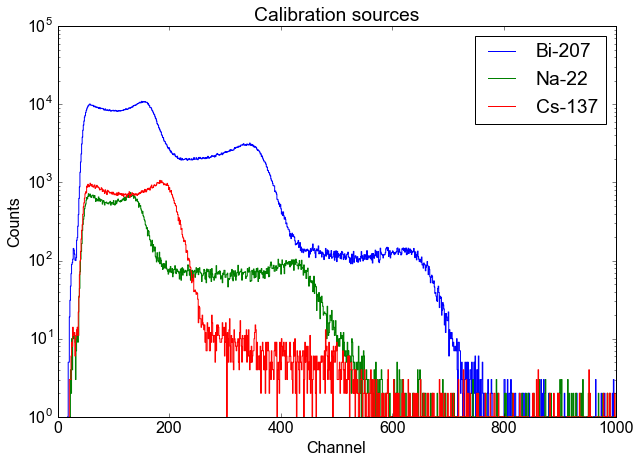

In [5]:
if plot:
    # Here we import the spectra one by one and plot them
    for filename, label, color in zip(cal_filenames, cal_labels, my_colors):
        line_n = find_line_start(filename, '[DATA')
        spec = get_spectrum(filename, line_n)
        plt.plot(spec,linestyle='steps', label=label, color=color)
    #     fwhm_pos = get_fwhm_pos(spec)
    #     plt.axvline(get_fwhm_pos(spec), color=color)
    plt.yscale('log')
    plt.title("Calibration sources")
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.xlim(0,1000)
    plt.legend()
    plt.show()

In [6]:
# Now, determine the position of the Compton edges
# We make two lists: one storing the energy in keV and one the index of the half-max sample
energy_list   = []
fwhm_pos_list = []

for filename, label, color in zip(cal_filenames, cal_labels, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    if label == 'Bi-207':
        # Bi-207 has three gamma ray energies, so three Compton edges to find
        # https://ehs.ucsd.edu/rad/radionuclide/Bi-207.pdf
        energy_list.append(get_compton_energy(570.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1064.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:500]) + 300)
        energy_list.append(get_compton_energy(1770.))
        fwhm_pos_list.append(get_fwhm_pos(spec[500:800]) + 500)
    if label == 'Na-22':
        # From Na-22 we get 511 keV from positron allihilation and 1274 from gamma
        energy_list.append(get_compton_energy(511.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1274.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:600]) + 300)
    if label == 'Cs-137':
        # Only 662 keV
        energy_list.append(get_compton_energy(662.))
        fwhm_pos_list.append(get_fwhm_pos(spec))


Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


In [7]:
# Now perform the calibration based on linear fit
from scipy.optimize import curve_fit
p_scale, _ = curve_fit(poly_1, energy_list, fwhm_pos_list)
p_scale_and = [6, 1/4.775*2]

# Invert relation
p_scale_to_e = [- p_scale[0] / p_scale[1], 1 / p_scale[1]]
p_scale_to_e_and = [- p_scale_and[0] / p_scale_and[1], 1 / p_scale_and[1]]
# e_scale is the important list: it contains the energy in keV
# This is basically the x axis for all our next plots!
e_scale = np.array([poly_1(x, *p_scale_to_e) for x in range(4096)])
e_scale_and = np.array([poly_1(x, *p_scale_to_e_and) for x in range(4096)])

print("Erik Method:    Offset: %.2f channels, slope: %.4f channels/keV" % (p_scale[0], p_scale[1]))
print("Andreas Method: Offset: %.2f channels, slope: %.4f channels/keV" % (p_scale_and[0], p_scale_and[1]))


Erik Method:    Offset: 12.60 channels, slope: 0.4197 channels/keV
Andreas Method: Offset: 6.00 channels, slope: 0.4188 channels/keV


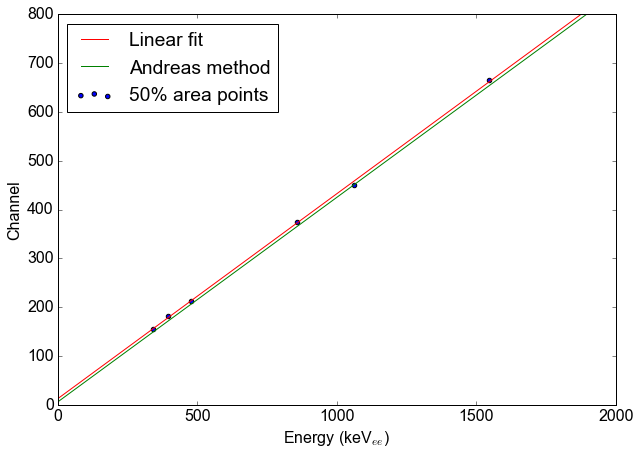

In [8]:
if plot:
    # Check out calibration
    plt.scatter(energy_list, fwhm_pos_list, label='50% area points')
    plt.plot(range(2000), [poly_1(x, *p_scale) for x in range(2000)], color='red', label='Linear fit')
    plt.plot(range(2000), [poly_1(x, *p_scale_and) for x in range(2000)], color='green', label='Andreas method')

    plt.xlabel('Energy (keV$_{ee}$)')
    plt.ylabel('Channel')
    plt.xlim(0,2000)
    plt.ylim(0,800)
    plt.legend(loc='upper left')
    plt.show()

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


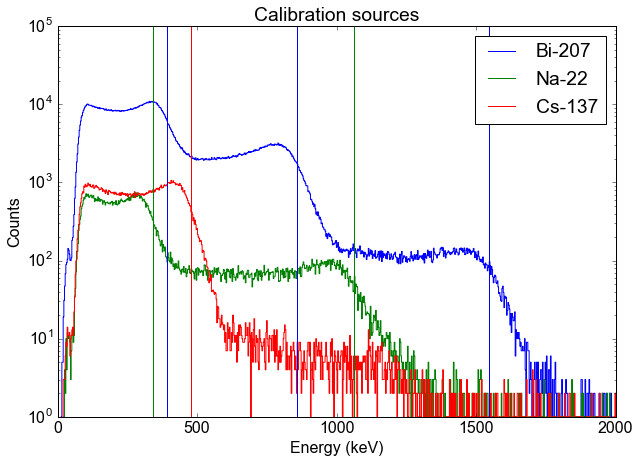

In [9]:
# Now plot the spectra again, but include with correct x scale and the Compton edge energy
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames, cal_labels, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    if plot:
        plt.plot(e_scale,spec,linestyle='steps', label=label, color=color)

if plot:
    for i, e in enumerate(np.sort(energy_list)):
        if i==0 or i==4:
            c = 'green'
        if i==1 or i==3 or i==5:
            c = 'blue'
        if i==2:
            c='red'
        plt.axvline(e, c=c)
    plt.yscale('log')
    plt.title("Calibration sources")
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.xlim(0,2000)
    plt.legend()
    plt.show()

#### Toggle calibration

In [10]:
guy_to_trust = 'andreas'

if guy_to_trust == 'andreas':
    e_scale = e_scale_and
    print("Selected Andreas' energy scale!")
if guy_to_trust == 'erik':
    e_scale = e_scale
    print("Selected Eriks energy scale!")

pickle.dump(e_scale, open('./08_ascii_files/e_scale.p', 'wb'))

Selected Andreas' energy scale!


### Load neutron and background data

In [11]:
# NG data
spec2d_list = []
for ng_filename in ng_filenames:
    line_n = find_line_start(ng_filename,'[CDAT2')
    spec2d_raw = get_spectrum(ng_filename, line_n)
    spec2d = np.reshape(spec2d_raw, (1024,4096))
    spec2d_list.append(spec2d)
#spec2d = sum(spec2d_list)

# NOTE THIS IS A NEW LINE... Only analize the first run, not all combined!
# NOTE modified AGAIN August 2016. spec2d = spec2d_list[0] -> spec2d = spec2d_list[0] + spec2d_list[1]
spec2d = spec2d_list[0] + spec2d_list[1]

Spectrum containing 4194304 samples read, total 976692 counts
Spectrum containing 4194304 samples read, total 1244420 counts
Spectrum containing 4194304 samples read, total 1867828 counts
Spectrum containing 4194304 samples read, total 3781471 counts
Spectrum containing 4194304 samples read, total 2050478 counts


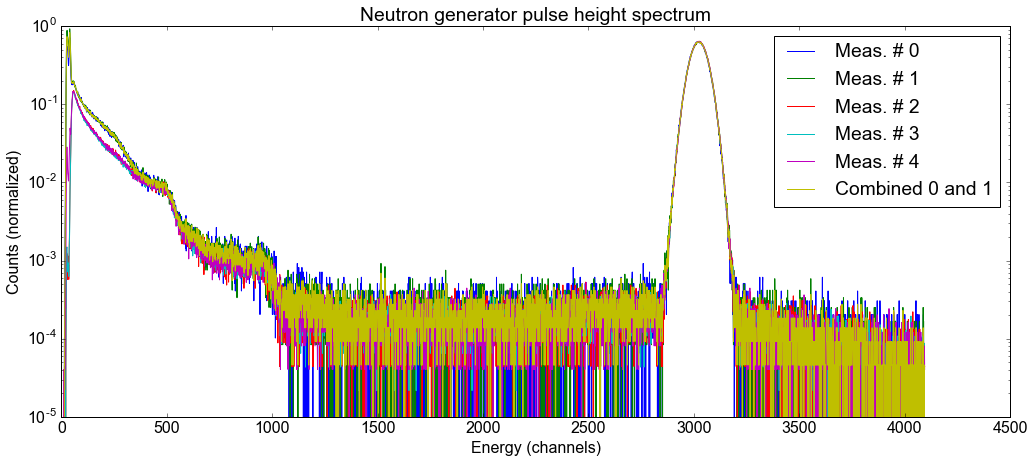

In [12]:
if plot:
    # Check that spectra coincide
    scale_it = True # Toggle scaling by the total livetime
    plt.figure(figsize=(17,7))
    for i, spec in enumerate(spec2d_list):
        if scale_it:
            #norm_fac = 1./np.sum(spec)
            norm_fac = 1/ng_livetimes[i]
        else:
            norm_fac = 1.
        plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)

    if scale_it:
        norm_fac = 1./(fg_livetime)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec2d, axis=0), label='Combined 0 and 1')
    plt.yscale('log')
    plt.legend()
    plt.title('Neutron generator pulse height spectrum')
    plt.xlabel('Energy (channels)')
    if scale_it:
        plt.ylabel('Counts (normalized)')
    else:
        plt.ylabel('Counts')
    plt.show()

In [13]:
# BG data
spec2d_bg_list = []
for bg_filename in bg_filenames:
    line_n = find_line_start(bg_filename,'[CDAT2')
    spec2d_raw = get_spectrum(bg_filename, line_n)
    spec2d_bg = np.reshape(spec2d_raw, (1024,4096))
    spec2d_bg_list.append(spec2d_bg)
# Sum the background
spec2d_bg = sum(spec2d_bg_list)

Spectrum containing 4194304 samples read, total 2968699 counts
Spectrum containing 4194304 samples read, total 3252444 counts


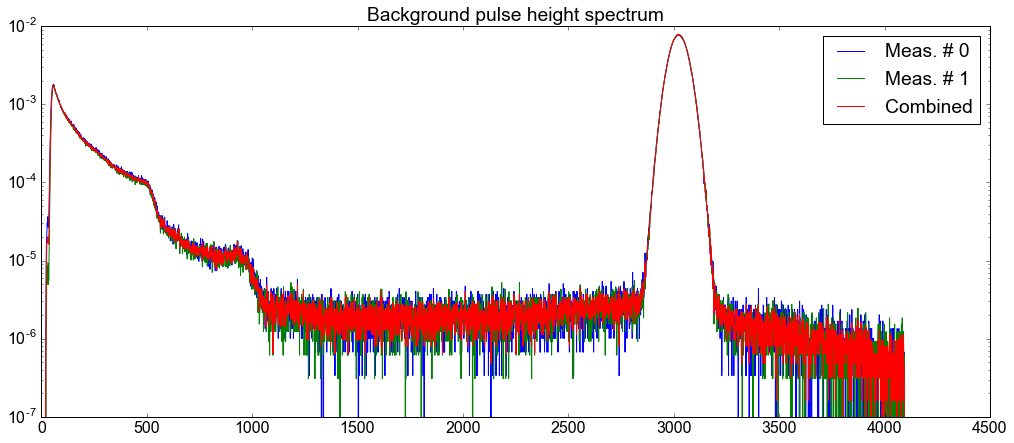

In [14]:
if plot:
    # Check that spectra coincide
    scale_it = True # Toggle scaling by the total number of counts
    plt.figure(figsize=(17,7))
    for i, spec in enumerate(spec2d_bg_list):
        if scale_it:
            norm_fac = 1./np.sum(spec)
        else:
            norm_fac = 1.
        plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
    if scale_it:
        norm_fac = 1./np.sum(spec2d_bg)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec2d_bg, axis=0), label='Combined')
    plt.yscale('log')
    plt.title('Background pulse height spectrum')
    plt.legend()
    plt.show()

### Cut background away

One thing we can do is cut the BG away based on the background discrimination parameter. For this, we have to calculate some cut parameter. I build a class to perform the cut based on a percentile of the BG distribution in y.

#### Cut class defintion

In [15]:
class Cut:
    '''
    Produce a cut function to cut on a percentile list.
    '''
    
    pct = 0.
    pct_list = [True for x in range(4096) ] 
    x_thr = 0.
    y_thr = 0.
    
    def get_percentile(self, spec2d, pct):
        self.pct_list = []
        self.pct = pct
        for x in range(len(spec2d[0])):
            self.pct_list.append(self.get_percentile_pos(spec2d[:,x],pct))
        
    def get_percentile_pos(self, dist, percent):
        tot = sum(dist)
        count = 0
        for i, x in enumerate(dist):
            if count >= tot*percent/100.:
                return i
            count += x
        # We should never arrive here
        print('WARNING! Error in get_percentile_pos')
        return -1
    
    def f_cut(self, x, y):
        '''
        FALSE = CUT
        TRUE = KEEP
        '''
        cut_y = self.pct_list[x-1]
        if y < cut_y:
            return False
        if x < self.x_thr:
            return False
        if y < self.y_thr:
            return False
        else:
            return True
        
    def plot_bounds(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)
        plt.axvline(self.x_thr, **kwargs)
        plt.axhline(self.y_thr, **kwargs)
        
    def plot_percentile(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)

#### Calculate cuts

In [16]:
cut_list = []
# 99 percent looks good, add to this list if you disagree
for percentile in [99.0]:
    cut = Cut()
    cut.get_percentile(spec2d_bg, percentile)
    cut_list.append(cut)

#### Show cuts on background and foreground

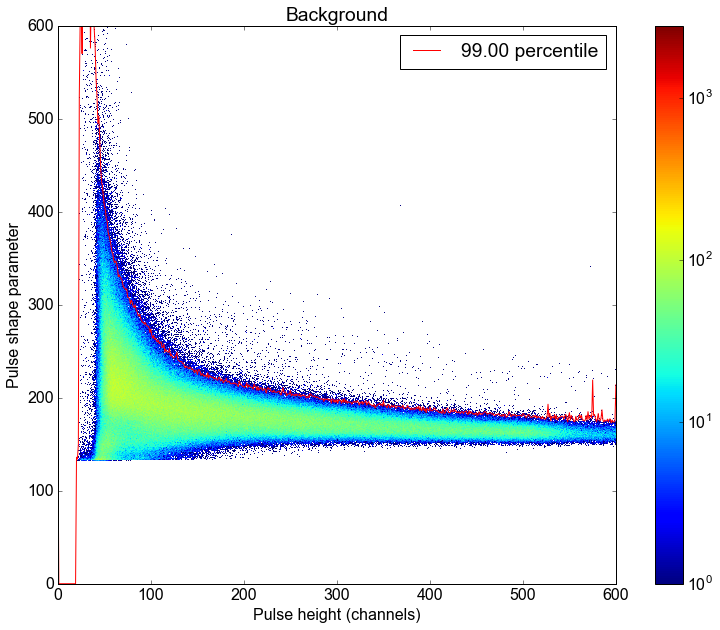

In [17]:
if plot:
    plt.figure(figsize=(14,10))
    im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                    norm=LogNorm())
    for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
        cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
    plt.colorbar()
    plt.xlim(0,600)
    plt.ylim(0,600)
    plt.title('Background')
    plt.legend()
    plt.xlabel('Pulse height (channels)')
    plt.ylabel('Pulse shape parameter')
    plt.show()

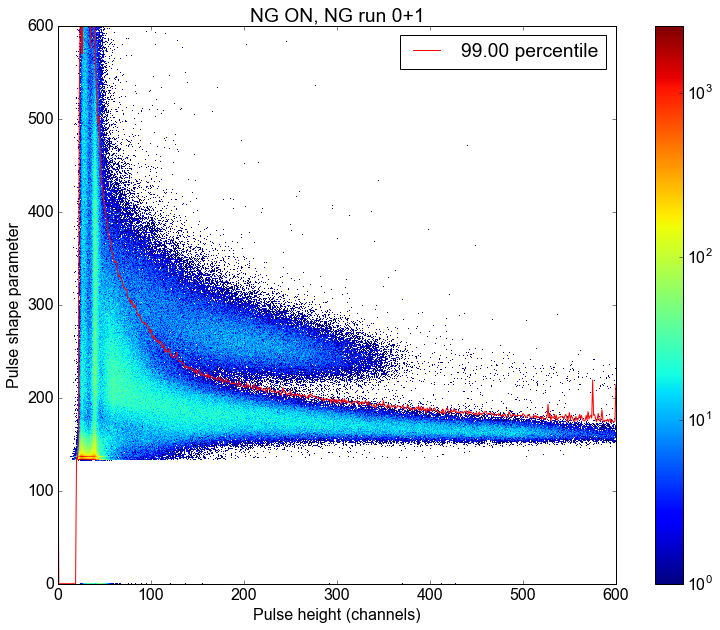

In [18]:
if plot:
    plt.figure(figsize=(14,10))
    im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                    norm=LogNorm())
    for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
        cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
    plt.colorbar()
    plt.xlim(0,600)
    plt.ylim(0,600)
    plt.title('NG ON, NG run 0+1')
    plt.legend()
    plt.xlabel('Pulse height (channels)')
    plt.ylabel('Pulse shape parameter')
    plt.show()

#### Apply cut

In [19]:
# cut_list[0] means we're taking the 99.0 % cut
# cut_list[1] means we're taking the 99.5 % cut
cut = cut_list[0]
cut.x_thr = 48.
print('Threshold is at %.1f keVee' % e_scale[cut.x_thr])
spec2d_cut = cut_hist2d(spec2d, cut.f_cut)
spec2d_bg_cut = cut_hist2d(spec2d_bg, cut.f_cut)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Threshold is at 100.3 keVee


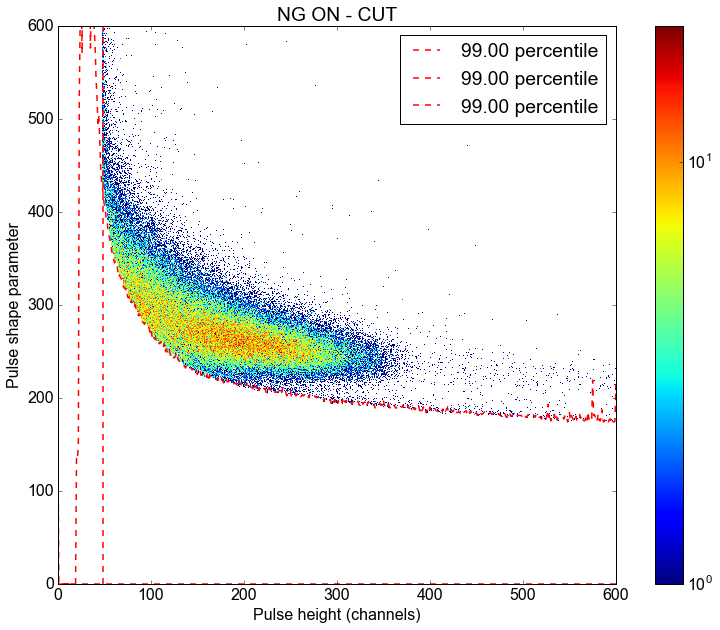

In [20]:
if plot:
    plt.figure(figsize=(14,10))
    im = plt.imshow(spec2d_cut, origin='low', interpolation='none', # interpolation='nearest'
                    norm=LogNorm())
    plt.colorbar()
    plt.xlim(0,600)
    plt.ylim(0,600)
    plt.title('NG ON - CUT')
    cut.plot_bounds(color='red', ls='--', lw=1.5, label='%.2f percentile' % cut.pct)
    plt.legend()
    plt.xlabel('Pulse height (channels)')
    plt.ylabel('Pulse shape parameter')
    plt.show()

#### Calculate cut spectra for all NG runs

In [21]:
# Settings equal for all runs
cut = cut_list[0]
cut.x_thr = 48.

# Now, for all runs:
# - Take 2d spectrum
# - Apply cuts based on BG percentiles
# - Project on x axis to obtain 1d (energy) spectrum
# - Divide by lifetime or run 
fg_disc   = 1/fg_livetime*np.sum((cut_hist2d(spec2d_list[0], cut.f_cut) + cut_hist2d(spec2d_list[1], 
                                                                                                 cut.f_cut)), axis=0)
fg_0_disc = 1/ng_livetimes[0]*np.sum(cut_hist2d(spec2d_list[0], cut.f_cut), axis=0)
fg_1_disc = 1/ng_livetimes[1]*np.sum(cut_hist2d(spec2d_list[1], cut.f_cut), axis=0)
fg_2_disc = 1/ng_livetimes[2]*np.sum(cut_hist2d(spec2d_list[2], cut.f_cut), axis=0)
fg_3_disc = 1/ng_livetimes[3]*np.sum(cut_hist2d(spec2d_list[3], cut.f_cut), axis=0)
fg_4_disc = 1/ng_livetimes[4]*np.sum(cut_hist2d(spec2d_list[4], cut.f_cut), axis=0)



# Calculate errors:
# - Assume only Poissonian errors
# WARNING: - uncertainty on cut is NOT taken into account
# WARNING: - zero error for zero count, screws all fits up.
fg_disc_err   = 1/fg_livetime*np.sqrt(np.sum((cut_hist2d(spec2d_list[0], cut.f_cut) + cut_hist2d(spec2d_list[1], 
                                                                                                 cut.f_cut)), axis=0))
fg_0_disc_err = 1/ng_livetimes[0]*np.sqrt(np.sum(cut_hist2d(spec2d_list[0], cut.f_cut), axis=0))
fg_1_disc_err = 1/ng_livetimes[1]*np.sqrt(np.sum(cut_hist2d(spec2d_list[1], cut.f_cut), axis=0))
fg_2_disc_err = 1/ng_livetimes[2]*np.sqrt(np.sum(cut_hist2d(spec2d_list[2], cut.f_cut), axis=0))
fg_3_disc_err = 1/ng_livetimes[3]*np.sqrt(np.sum(cut_hist2d(spec2d_list[3], cut.f_cut), axis=0))
fg_4_disc_err = 1/ng_livetimes[4]*np.sqrt(np.sum(cut_hist2d(spec2d_list[4], cut.f_cut), axis=0))

# Also for BG, because this is how much of the BG leaks into signal!
bg_disc = 1/bg_livetime*np.sum(cut_hist2d(spec2d_bg, cut.f_cut), axis=0)
bg_disc_err = 1/bg_livetime*np.sqrt(np.sum(cut_hist2d(spec2d_bg, cut.f_cut), axis=0))

# Subtract BG leakage
fg_disc_sub = fg_disc - bg_disc
fg_disc_sub_err = np.sqrt(fg_disc_err**2 + bg_disc_err**2)

#### Show cut pulse height spectra

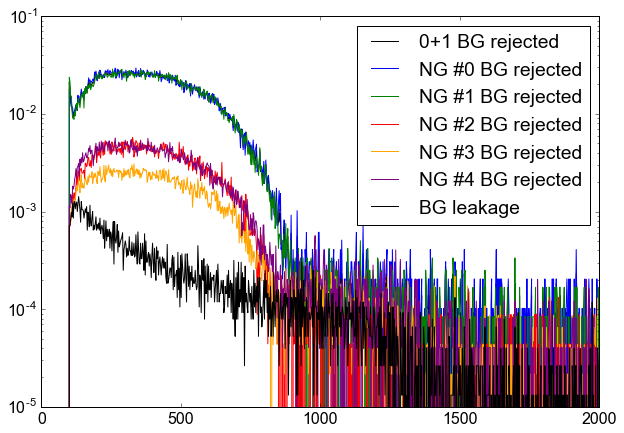

In [22]:
if plot:
    plt.plot(e_scale, fg_disc, color='black',  label='0+1 BG rejected')
    plt.plot(e_scale, fg_0_disc, color='blue', label='NG #0 BG rejected')
    plt.plot(e_scale, fg_1_disc, color='green', label='NG #1 BG rejected')
    plt.plot(e_scale, fg_2_disc, color='red', label='NG #2 BG rejected')
    plt.plot(e_scale, fg_3_disc, color='orange', label='NG #3 BG rejected')
    plt.plot(e_scale, fg_4_disc, color='purple', label='NG #4 BG rejected')
    plt.plot(e_scale, bg_disc, color='black', label='BG leakage')

    plt.xlim(0,2000)
    #plt.ylim(0,0.007)
    plt.legend()
    plt.yscale('log')


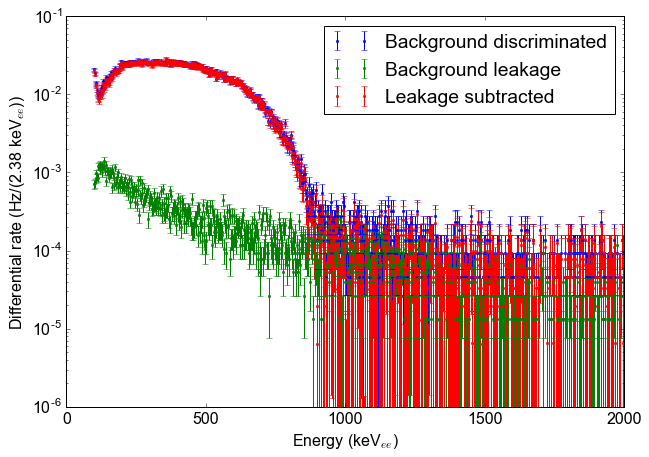

In [23]:
if plot:
    plt.errorbar(e_scale, fg_disc, fg_disc_err, linestyle='none', marker='.', markersize=5,  label='Background discriminated')
    plt.errorbar(e_scale, bg_disc, bg_disc_err, linestyle='none', marker='.', markersize=5,  label='Background leakage')
    plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, linestyle='none', marker='.', markersize=5,  
                 label='Leakage subtracted')
    plt.xlim(0,2000)
    plt.yscale('log')

    plt.xlabel('Energy (keV$_{ee}$)')
    plt.ylabel('Differential rate (Hz/(2.38 keV$_{ee}$))')
    plt.legend()


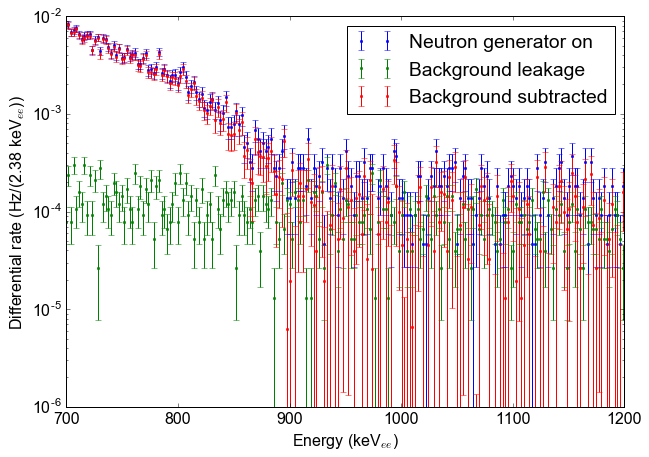

In [24]:
if plot:
    plt.errorbar(e_scale, fg_disc, fg_disc_err, linestyle='none', marker='.', markersize=5,  label='Neutron generator on')
    plt.errorbar(e_scale, bg_disc, bg_disc_err, linestyle='none', marker='.', markersize=5,  label='Background leakage')
    plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, linestyle='none', marker='.', markersize=5,  
                 label='Background subtracted')

    plt.xlim(700,1200)
    plt.yscale('log')
    plt.ylim(0.000001,0.01)

    plt.xlabel('Energy (keV$_{ee}$)')
    plt.ylabel('Differential rate (Hz/(2.38 keV$_{ee}$))')
    plt.legend()


### Subtract BG

#### Plot spectra

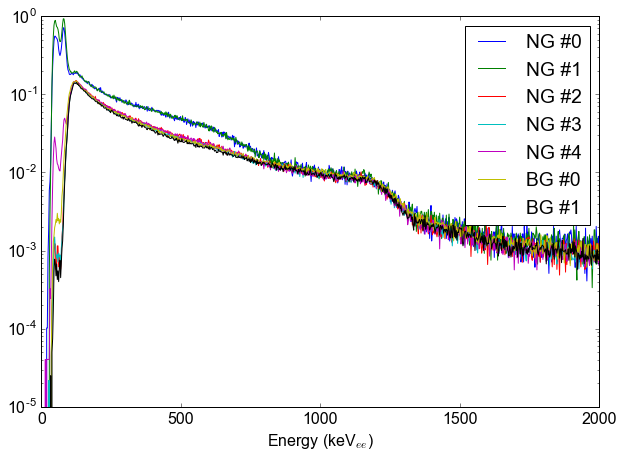

In [25]:
if plot:
    for i in range(len(spec2d_list)):
        plt.plot(e_scale, 1/ng_livetimes[i]*np.sum(spec2d_list[i],axis=0), label = 'NG #%d' % i)
    for i in range(len(spec2d_bg_list)):
        plt.plot(e_scale, 1/bg_livetimes[i]*np.sum(spec2d_bg_list[i],axis=0), label = 'BG #%d' % i)

    plt.xlabel('Energy (keV$_{ee}$)')
    plt.legend()
    plt.xlim(0,2000)
    plt.yscale('log')

#### Compute spectra and errors

In [26]:
# Compute the livetime-corrected energy spectra
fg   = 1/(fg_livetime)*np.sum((spec2d_list[0] + spec2d_list[1]),axis=0)
fg_0 = 1/ng_livetimes[0]*np.sum(spec2d_list[0],axis=0)
fg_1 = 1/ng_livetimes[1]*np.sum(spec2d_list[1],axis=0)
fg_2 = 1/ng_livetimes[2]*np.sum(spec2d_list[2],axis=0)
fg_3 = 1/ng_livetimes[3]*np.sum(spec2d_list[3],axis=0)
fg_4 = 1/ng_livetimes[4]*np.sum(spec2d_list[4],axis=0)


# Combine BG: take sum of counts and sum of livetimes
bg = (1/bg_livetime)*(np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0))

# Compute the errors
fg_err   = 1/fg_livetime*np.sqrt(np.sum((spec2d_list[0] + spec2d_list[1]),axis=0))
fg_0_err = 1/ng_livetimes[0]*np.sqrt(np.sum(spec2d_list[0],axis=0))
fg_1_err = 1/ng_livetimes[1]*np.sqrt(np.sum(spec2d_list[1],axis=0))
fg_2_err = 1/ng_livetimes[2]*np.sqrt(np.sum(spec2d_list[2],axis=0))
fg_3_err = 1/ng_livetimes[3]*np.sqrt(np.sum(spec2d_list[3],axis=0))
fg_4_err = 1/ng_livetimes[4]*np.sqrt(np.sum(spec2d_list[4],axis=0))

bg_err = (1/sum(bg_livetimes))*np.sqrt(
    (np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0)))

# Subtract BG
fg_sub = fg - bg
fg_0_sub = fg_0 - bg
fg_1_sub = fg_1 - bg
fg_2_sub = fg_2 - bg
fg_3_sub = fg_3 - bg
fg_4_sub = fg_4 - bg

# Compute errors for subtracted BG plot
fg_sub_err = np.sqrt(fg_err**2 + bg_err**2)
fg_0_sub_err = np.sqrt(fg_0_err**2 + bg_err**2)
fg_1_sub_err = np.sqrt(fg_1_err**2 + bg_err**2)
fg_2_sub_err = np.sqrt(fg_2_err**2 + bg_err**2)
fg_3_sub_err = np.sqrt(fg_3_err**2 + bg_err**2)
fg_4_sub_err = np.sqrt(fg_4_err**2 + bg_err**2)

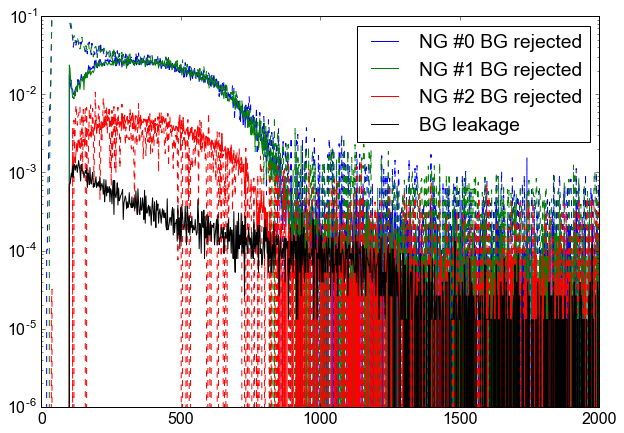

In [27]:
if plot:
    plt.plot(e_scale, fg_0_disc, color='blue', label='NG #0 BG rejected')
    plt.plot(e_scale, fg_0_sub, color='blue',ls='--')
    plt.plot(e_scale, fg_1_disc, color='green', label='NG #1 BG rejected')
    plt.plot(e_scale, fg_1_sub, color='green', ls='--')
    plt.plot(e_scale, fg_2_disc, color='red', label='NG #2 BG rejected')
    plt.plot(e_scale, fg_2_sub, color='red', ls='--')
    plt.plot(e_scale, bg_disc, color='black', label='BG leakage')

    plt.xlim(0,2000)
    plt.ylim(1e-6, 1e-1)
    plt.legend()
    plt.yscale('log')

### Investigate high energy population

#### Simple rebinning

In [28]:
def get_percentile_location(arr, pct):
    '''
    No idea why fucking numpy doesnt work on 1d arrays gvd
    '''
    total = sum(arr)
    current_sum = 0.
    i = 0
    while current_sum < total*pct:
        current_sum += arr[i]
        i += 1
    return i

In [29]:
def rebin(arr, factor=2, mode='avg'):
    '''
    Rebin an array. Take integer factor. Modes available:
      - avg: average. Default.
      - sum: Sum.
      - quad: adding all in quadrature. Mostly for errors.
      - quad_avg: adding all in quadrature, then taking average. For errors on averages.
    '''
    if mode == 'avg':
        rebin = np.array([1/factor*sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'sum':
        rebin = np.array([sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad':
        rebin = np.array([np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad_avg':
        rebin = np.array([1/factor*np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    else:
        raise SyntaxError('Did not get the rebinning mode, you specified: %s' % mode)
    
    return rebin

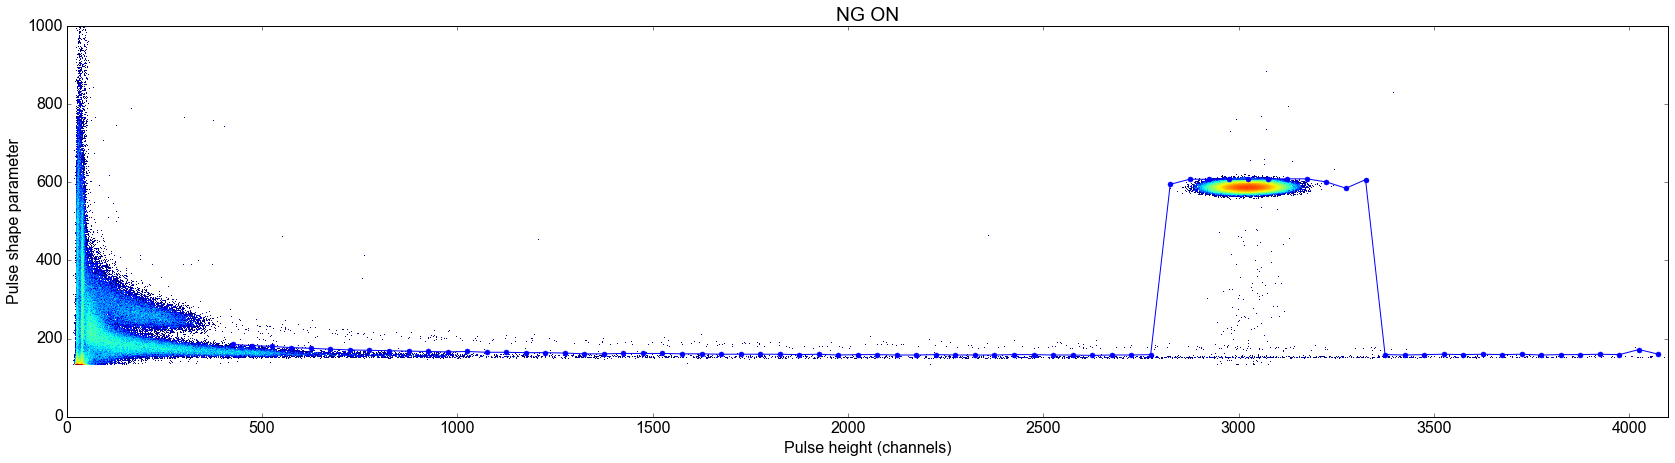

In [30]:
pct = 0.99
cutoffs = []
e_scale_he_bins = []
fg_he = []
bg_he = []

for limit in np.arange(400, 4096, 50):
    dist_bg = np.sum(spec2d_bg[:, limit:limit+50], axis=1)
    current_cutoff = get_percentile_location(dist_bg, pct)
    cutoffs.append(current_cutoff)
    e_scale_he_bins.append(limit+25)
    fg_he.append(np.sum(spec2d[current_cutoff:, limit:limit+50]))
    bg_he.append(np.sum(spec2d_bg[current_cutoff:, limit:limit+50]))
    
# Show the cut
if plot:
    plt.figure(figsize=(30,7))
    im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                    norm=LogNorm())

    plt.plot(e_scale_he_bins, cutoffs, marker='.', markersize=10, linestyle='solid')
    plt.xlim(0,4100)
    plt.ylim(0,1000)
    plt.title('NG ON')
    plt.xlabel('Pulse height (channels)')
    plt.ylabel('Pulse shape parameter')
    plt.savefig('./he_population.pdf')
    plt.show()


e_scale_he = poly_1(np.array(e_scale_he_bins), *p_scale_to_e_and)

# Make arrays to enable numpy magic!
# NOTE that these are still NUMBERS and not rate!
fg_he = np.array(fg_he)
bg_he = np.array(bg_he)

# Now calculate Poissonian errors
fg_he_err = 1/(ng_livetimes[0] + ng_livetimes[1])*np.sqrt(fg_he)
bg_he_err = 1/sum(bg_livetimes)*np.sqrt(bg_he)

fg_he = 1/(ng_livetimes[0] + ng_livetimes[1])*fg_he
bg_he = 1/sum(bg_livetimes)*bg_he

fg_he_sub = fg_he - bg_he
fg_he_sub_err = np.sqrt(bg_he_err**2 + fg_he_err**2)



In [31]:
# Need for 'nicer histogram'  instead of imshow
# We make event-by-event lists of values that we can histogram, instead of setting bin content.
spec2d_counts_x = []
spec2d_counts_y = []

for i in range(len(spec2d)):
    for j in range(len(spec2d[0])):
        for k in range(spec2d[i,j]):
            spec2d_counts_y.append(i)
            spec2d_counts_x.append(j)
spec2d_counts_x = np.array(spec2d_counts_x)
spec2d_counts_y = np.array(spec2d_counts_y)

# Same for bg...
spec2d_bg_counts_x = []
spec2d_bg_counts_y = []

for i in range(len(spec2d_bg)):
    for j in range(len(spec2d_bg[0])):
        for k in range(spec2d_bg[i,j]):
            spec2d_bg_counts_y.append(i)
            spec2d_bg_counts_x.append(j)
spec2d_bg_counts_x = np.array(spec2d_bg_counts_x)
spec2d_bg_counts_y = np.array(spec2d_bg_counts_y)

### Better event selection(?)

In [32]:
%run plots.ipynb

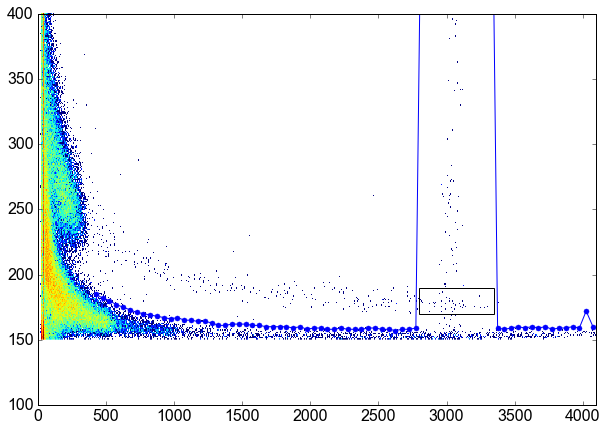

In [33]:
ymin = 150
ymax = 400

plt.hist2d(spec2d_counts_x,spec2d_counts_y, bins=(4096, ymax - ymin), range=((0,4096), (ymin, ymax)), norm=LogNorm())
plt.ylim(100,400)
plt.plot(e_scale_he_bins, cutoffs, marker='.', markersize=10, linestyle='solid')
draw_box((2800,3350),(170,190), facecolor='None')
plt.show()

In [34]:
led_region = np.array(e_scale_he_bins)[np.array(cutoffs) > 200]

In [35]:
# For new values first just take the values we found previously
fg_he_proper = fg_he.copy()
fg_he_err_proper = fg_he_err.copy()
bg_he_proper = bg_he.copy()
bg_he_err_proper = bg_he_err.copy()
fg_he_sub_proper = fg_he_sub.copy()
fg_he_sub_err_proper = fg_he_sub_err.copy()

for i, e in enumerate(e_scale_he_bins):
    if e in led_region:
        fg_he_proper[i] = np.sum(spec2d[170:190, e-25:e+25])
        bg_he_proper[i] = np.sum(spec2d_bg[170:190, e-25:e+25])
        # Now calculate Poissonian errors
        fg_he_err_proper[i] = 1/(ng_livetimes[0] + ng_livetimes[1])*np.sqrt(fg_he_proper[i])
        bg_he_err_proper[i] = 1/sum(bg_livetimes)*np.sqrt(bg_he_proper[i])

        fg_he_proper[i] = 1/(ng_livetimes[0] + ng_livetimes[1])*fg_he_proper[i]
        bg_he_proper[i] = 1/sum(bg_livetimes)*bg_he_proper[i]

        fg_he_sub_proper[i] = fg_he_proper[i] - bg_he_proper[i]
        fg_he_sub_err_proper[i] = np.sqrt(bg_he_err_proper[i]**2 + fg_he_err_proper[i]**2)

In [36]:
led_region

array([2825, 2875, 2925, 2975, 3025, 3075, 3125, 3175, 3225, 3275, 3325])

(0, 100)

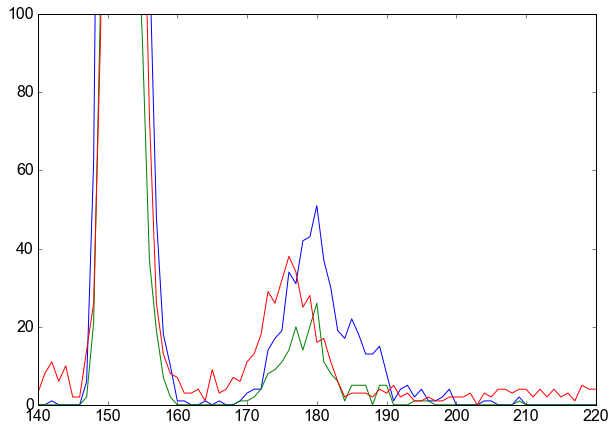

In [37]:
plt.plot(np.sum(spec2d[:,2000:2800], axis=1), label='2000-2800')
plt.plot(np.sum(spec2d[:,2500:2800], axis=1), label='2500-2800')
plt.plot(np.sum(spec2d[:,2800:3350], axis=1), label='2800-3350')

plt.xlim(140,220)
plt.ylim(0,100)

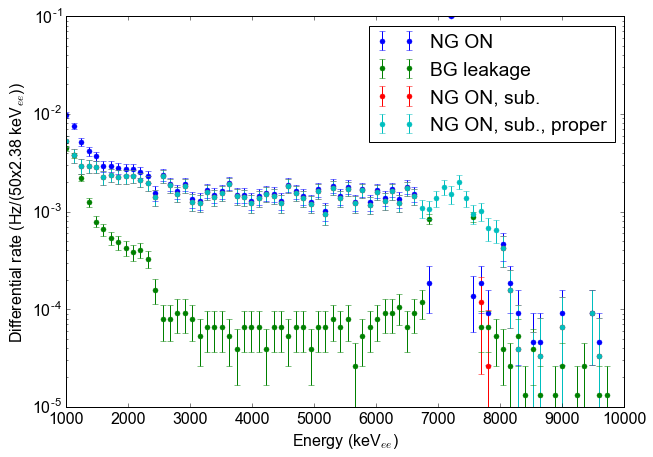

In [38]:
if plot:
    plt.errorbar(e_scale_he,fg_he, fg_he_err, ls='none',marker='.', markersize=10, label='NG ON')
    plt.errorbar(e_scale_he,bg_he, bg_he_err, ls='none',marker='.', markersize=10, label='BG leakage')
    plt.errorbar(e_scale_he,fg_he_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')
    plt.errorbar(e_scale_he,fg_he_sub_proper, fg_he_sub_err_proper, ls='none',marker='.', 
                 markersize=10, label='NG ON, sub., proper')
    plt.ylim(0.00001,1e-1)
    plt.yscale('log')
    plt.xlabel('Energy (keV$_{ee}$)')
    plt.ylabel('Differential rate (Hz/(50x2.38 keV$_{ee}$))')
    plt.legend()
    plt.show()

## Rebinning

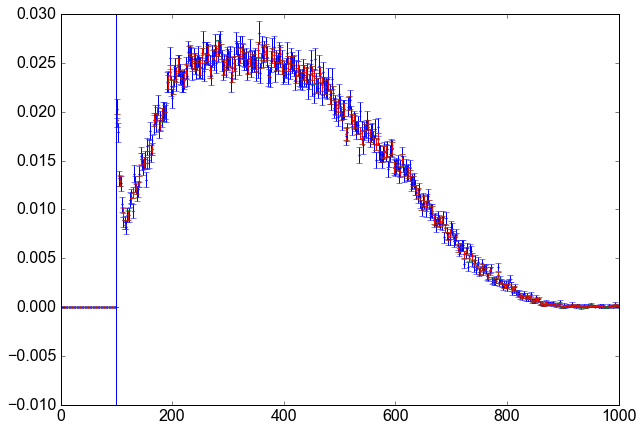

In [39]:
e_scale_r = rebin(e_scale, mode='avg') # r for rebin
fg_disc_sub_r = rebin(fg_disc_sub, mode='avg')
fg_disc_sub_err_r = rebin(fg_disc_sub_err, mode='quad_avg')
# Manual calculation with other method confirms the error bars
ehm = np.sqrt(abs(rebin(fg_disc_sub, mode = 'sum') * fg_livetime)) / fg_livetime / 2
# acc_e_r = rebin(acc_e, mode='avg')

plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, marker='.', markersize=3, ls='None')
plt.errorbar(e_scale_r, fg_disc_sub_r, fg_disc_sub_err_r, marker='.', markersize=3, ls='None')
plt.errorbar(e_scale_r, fg_disc_sub_r, ehm, marker='.', markersize=3, ls='None')
plt.xlim(0,1000)
plt.axvline(100)
plt.show()

# def correct_for_acc(arr, acceptance_array, cutoff = 1e-6):
#     assert len(arr) == len(acceptance_array)
#     arr_c = []
#     for a, acc in zip(arr, acceptance_array):
#         if acc < cutoff:
#             arr_c.append(0)
#         else:
#             arr_c.append(a/acc)
#     return np.array(arr_c)

# fg_disc_sub_r_a = correct_for_acc(fg_disc_sub_r, acc_e_r)
# fg_disc_sub_err_r_a = correct_for_acc(fg_disc_sub_err_r, acc_e_r)

# plt.errorbar(e_scale_r, fg_disc_sub_r, fg_disc_sub_err_r)
# plt.errorbar(e_scale_r, fg_disc_sub_r_a, fg_disc_sub_err_r_a)
# plt.xlim(0,1000)
# plt.axvline(100)
# plt.axvline(120)
# plt.ylim(0,0.1)

## Paper Plots

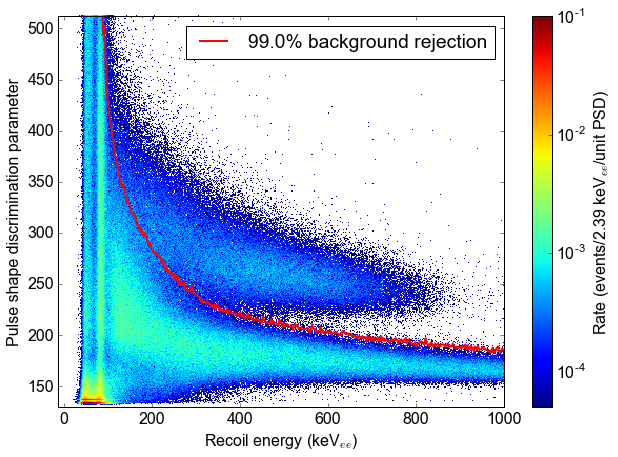

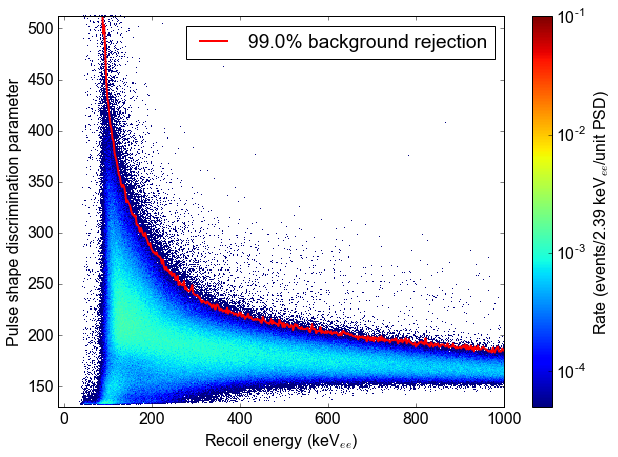

In [40]:
cut = cut_list[0]
rebin_x = 1
rebin_y = 1
x_max = 1000 # keVee
y_max = 512 # bins
y_min = 130 # bins
start_cut_line = 40 # Remove the red bg rejection line before this bin in energy (is not equal to keV!)

# This is to avoid vertical lines (no-data lines)
nbins_x = len(e_scale_and[e_scale_and < x_max])
x_min = e_scale_and[0]
x_max = e_scale_and[nbins_x]

w_fg = [1/fg_livetime for _ in spec2d_counts_x]
w_bg = [1/bg_livetime for _ in spec2d_bg_counts_x]


plt.figure(figsize=(10,7))
plt.hist2d(poly_1(spec2d_counts_x, *p_scale_to_e_and), spec2d_counts_y, bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y), 
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_fg, vmin=5e-5, vmax=1e-1)
plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.colorbar(label = 'Rate (events/2.39 keV$_{ee}$/unit PSD)')
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Pulse shape discrimination parameter')
plt.legend()
plt.savefig('./figs/hist2d_ng.png', bbox_inches = 'tight')
plt.savefig('./figs/hist2d_ng.pdf', bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(10,7))
plt.hist2d(poly_1(spec2d_bg_counts_x, *p_scale_to_e_and), spec2d_bg_counts_y, 
           bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y),  
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_bg, vmin=5e-5, vmax=1e-1)
plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.colorbar(label = 'Rate (events/2.39 keV$_{ee}$/unit PSD)')
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Pulse shape discrimination parameter')
plt.legend()
plt.savefig('./figs/hist2d_bg.png', bbox_inches = 'tight')
plt.savefig('./figs/hist2d_bg.pdf', bbox_inches = 'tight')
plt.show()

### Paper plot remake

In [41]:
def closest_element_pos(arr, number):
    diff = list(np.abs(arr - number))
    return diff.index(min(diff))

In [42]:
e_scale[:6]

array([-14.325 , -11.9375,  -9.55  ,  -7.1625,  -4.775 ,  -2.3875])

In [43]:
closest_element_pos(e_scale, 0)

6

x-range changed to 97.887500 to 1000.362500 keVee, 379 bins


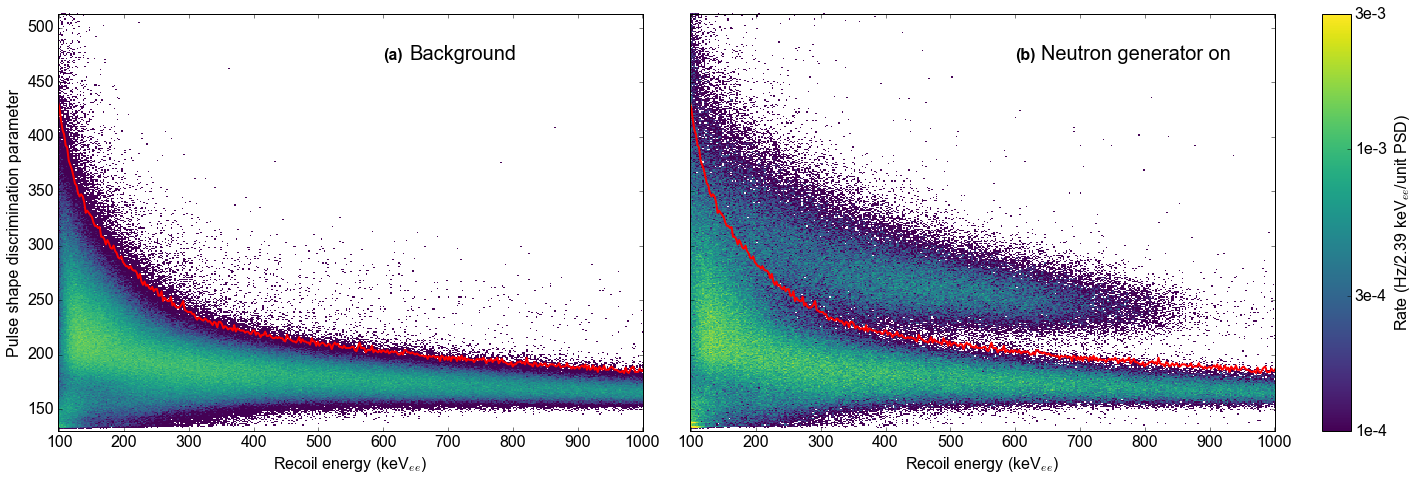

In [52]:
from matplotlib import gridspec
plt.set_cmap('viridis')

# SETTINGS
cut = cut_list[0]
rebin_x = 1
rebin_y = 1
x_min = 98 # keVee
x_max = 1000 # keVee
y_max = 512 # bins
y_min = 130 # bins
start_cut_line = 40 # Remove the red bg rejection line before this bin in energy (is not equal to keV!)

# DERIVED VALUES
# This is to avoid vertical lines (no-data lines)
x_min_bins = closest_element_pos(e_scale_and, x_min)
x_max_bins = closest_element_pos(e_scale_and, x_max)
# Where the +1 comes from? Fencepost shit. I'll never get it I swear
nbins_x = x_max_bins - x_min_bins + 1 
# Round to value in list
x_min = e_scale_and[x_min_bins]
x_max = e_scale_and[x_max_bins]
print('x-range changed to %f to %f keVee, %d bins' % (x_min, x_max, nbins_x))

# Scale for livetime
w_fg = [1/fg_livetime for _ in spec2d_counts_x]
w_bg = [1/bg_livetime for _ in spec2d_bg_counts_x]

# INITIALIZE FIGURE
f = plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,0.05], hspace=-50) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

# PLOT BG SPECTRUM
plt.sca(ax1)
bg_plot = plt.hist2d(poly_1(spec2d_bg_counts_x, *p_scale_to_e_and), spec2d_bg_counts_y, 
           bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y),  
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_bg, vmin=1e-4, vmax=3e-3)

plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Pulse shape discrimination parameter')
# Enable bold font
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_weight('bold')
plt.text(600, 470, '(a)', fontsize=25, fontproperties = font)
plt.text(640, 470, 'Background', fontsize=20)
ax1.xaxis.set_ticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

# PLOT FG SPECTRUM
plt.sca(ax2)
plt.hist2d(poly_1(spec2d_counts_x, *p_scale_to_e_and), spec2d_counts_y, bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y), 
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_fg, vmin=1e-4, vmax=3e-3)
plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.xlabel('Recoil energy (keV$_{ee}$)')
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.text(600, 470, '(b)', fontsize=25, fontproperties = font)
plt.text(640, 470, 'Neutron generator on', fontsize=20)

# PLOT COLORBAR
plt.sca(ax3)
cbar = plt.colorbar(bg_plot[-1],cax = ax3, label = 'Rate (Hz/2.39 keV$_{ee}$/unit PSD)')
cticks = [1e-4, 3e-4, 1e-3, 3e-3]
ctick_labels = ['1e-4', '3e-4', '1e-3', '3e-3']
cbar.set_ticks(cticks)
cbar.ax.set_yticklabels(ctick_labels)
gs.tight_layout(f)

# JAY! WE'RE DONE
plt.savefig('./figs/hist2d_bg_and_fg.png', bbox_inches = 'tight')
plt.savefig('./figs/hist2d_bg_and_fg.pdf', bbox_inches = 'tight')
plt.show()

### Presentation version

x-range changed to -0.000000 to 1000.362500 keVee, 420 bins


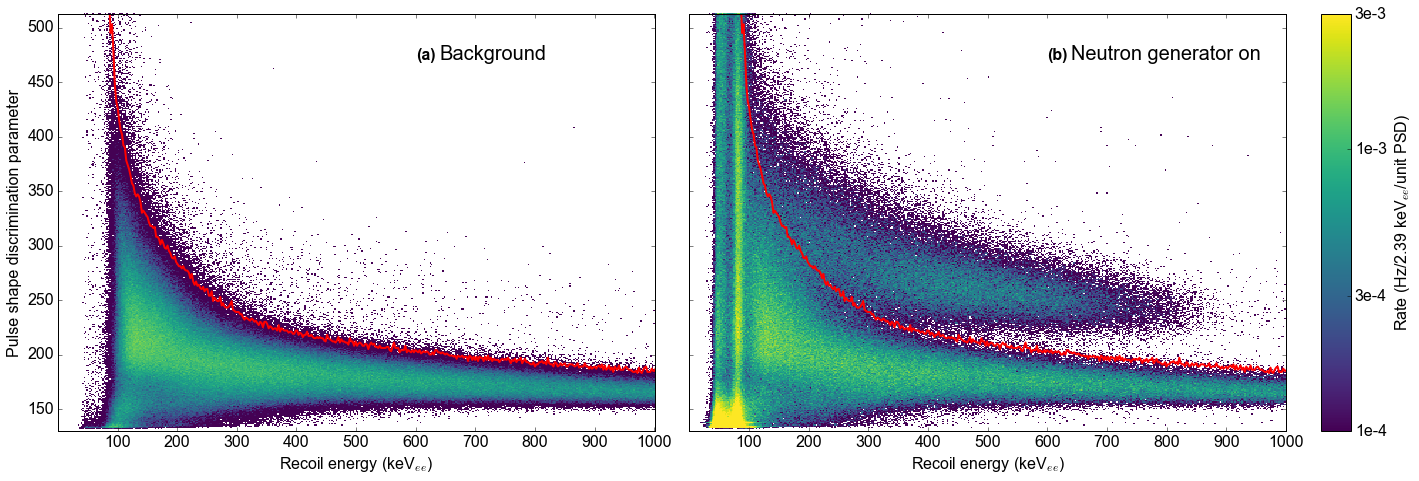

In [51]:
# SETTINGS
cut = cut_list[0]
rebin_x = 1
rebin_y = 1
x_min = 0 # keVee
x_max = 1000 # keVee
y_max = 512 # bins
y_min = 130 # bins
start_cut_line = 40 # Remove the red bg rejection line before this bin in energy (is not equal to keV!)

# DERIVED VALUES
# This is to avoid vertical lines (no-data lines)
x_min_bins = closest_element_pos(e_scale_and, x_min)
x_max_bins = closest_element_pos(e_scale_and, x_max)
# Where the +1 comes from? Fencepost shit. I'll never get it I swear
nbins_x = x_max_bins - x_min_bins + 1 
# Round to value in list
x_min = e_scale_and[x_min_bins]
x_max = e_scale_and[x_max_bins]
print('x-range changed to %f to %f keVee, %d bins' % (x_min, x_max, nbins_x))

# Scale for livetime
w_fg = [1/fg_livetime for _ in spec2d_counts_x]
w_bg = [1/bg_livetime for _ in spec2d_bg_counts_x]

# INITIALIZE FIGURE
f = plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,0.05], hspace=-50) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

# PLOT BG SPECTRUM
plt.sca(ax1)
bg_plot = plt.hist2d(poly_1(spec2d_bg_counts_x, *p_scale_to_e_and), spec2d_bg_counts_y, 
           bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y),  
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_bg, vmin=1e-4, vmax=3e-3)

plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Pulse shape discrimination parameter')
# Enable bold font
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_weight('bold')
plt.text(600, 470, '(a)', fontsize=25, fontproperties = font)
plt.text(640, 470, 'Background', fontsize=20)
ax1.xaxis.set_ticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

# PLOT FG SPECTRUM
plt.sca(ax2)
plt.hist2d(poly_1(spec2d_counts_x, *p_scale_to_e_and), spec2d_counts_y, bins=(nbins_x/rebin_x,(y_max-y_min)/rebin_y), 
           norm=LogNorm(), range=((x_min,x_max),(y_min,y_max)), weights= w_fg, vmin=1e-4, vmax=3e-3)
plt.plot(e_scale_and[start_cut_line:], cut.pct_list[start_cut_line:], 
         color='red', lw=2, label='%.1f%% background rejection' %  cut.pct)
plt.xlabel('Recoil energy (keV$_{ee}$)')
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.text(600, 470, '(b)', fontsize=25, fontproperties = font)
plt.text(640, 470, 'Neutron generator on', fontsize=20)

# PLOT COLORBAR
plt.sca(ax3)
cbar = plt.colorbar(bg_plot[-1],cax = ax3, label = 'Rate (Hz/2.39 keV$_{ee}$/unit PSD)')
cticks = [1e-4, 3e-4, 1e-3, 3e-3]
ctick_labels = ['1e-4', '3e-4', '1e-3', '3e-3']
cbar.set_ticks(cticks)
cbar.ax.set_yticklabels(ctick_labels)
gs.tight_layout(f)

# JAY! WE'RE DONE
plt.savefig('./figs/pres_5.png', bbox_inches = 'tight')
plt.savefig('./figs/pres_5.pdf', bbox_inches = 'tight')
plt.show()

## Random other stuff

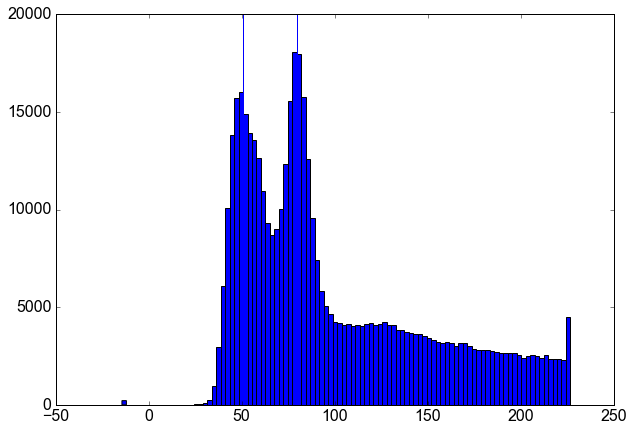

In [45]:
# Gamma lines at 51 and 80 keV
plot = True
if plot:
    nbins = 100
    plt.hist(poly_1(spec2d_counts_x, *p_scale_to_e_and), bins=nbins, range=(e_scale[0],e_scale[nbins+1]))
    # These are the energies that we see gammas at
    plt.axvline(51)
    plt.axvline(80)
    plt.show()

In [46]:
import time
time.clock()

145.517384

(100, 150)

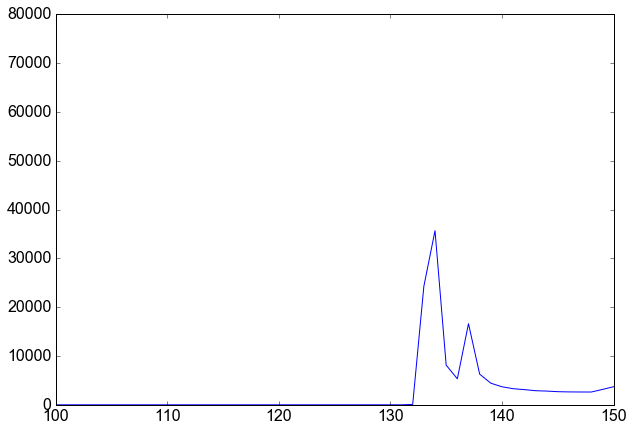

In [47]:

plt.plot(np.sum(spec2d, axis=1))
plt.xlim(100,150)

In [48]:
e_scale

array([ -1.43250000e+01,  -1.19375000e+01,  -9.55000000e+00, ...,
         9.75771250e+03,   9.76010000e+03,   9.76248750e+03])